# Models

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from category_encoders import MEstimateEncoder, TargetEncoder
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, LassoLarsCV
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.inspection import permutation_importance

In [3]:
df = pd.read_csv('./data_prepared.csv')

In [4]:
# Split into train/test
X = df.drop('Rating', axis=1)
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Encode categorical features and normalize numerical features.

In [143]:
class CatEncoder(TransformerMixin):
    def __init__(self, enc_name='MEstimateEncoder', **kwargs):
        exec('from category_encoders import %s' % enc_name)
        exec('self.encoder = %s(**kwargs)' % enc_name)
    
    def fit(self, X, y=None):
        return self.encoder.fit(X, y)
    
    def transform(self, X, y=None):
        return self.encoder.transform(X, y)
    
    def set_params(self, **params):
        print(params)
        return self.encoder.set_params(**params)

In [93]:
num_columns = ['Review Date', 'Cocoa Percent']
cat_columns = df_trans.select_dtypes(exclude='number').columns.tolist()

# Categorical encoding
#cat_enc = CatEncoder()
#cat_enc.fit(X_train, y_train)

#X_train_trans = cat_enc.transform(X_train, y_train)
#X_test_trans = cat_enc.transform(X_test, y_test)

# Normalize numerical columns
num_enc = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns)],
    remainder='passthrough')
#num_enc.fit(X_train_trans)

In [94]:
# Utility function for evaluation
def eval_mod(model):
    y_pred = model.predict(X_test)
    
    print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('MAE:', mean_absolute_error(y_test, y_pred))
    print('R^2:', r2_score(y_test, y_pred))

In [95]:
feature_names = X_train.columns

### Best encoder

In [146]:
encoders = ['CatBoostEncoder', 'GLMMEncoder', 'JamesSteinEncoder', 
            'LeaveOneOutEncoder', 'MEstimateEncoder', 'TargetEncoder']

for enc in encoders:
    lr_mod = Pipeline([('cat_enc', CatEncoder(enc)), 
                   ('scaler', num_enc), 
                   ('lr', LinearRegression())])
    lr_mod.fit(X_train, y_train)
    print(enc)
    eval_mod(lr_mod)
    print()

CatBoostEncoder
RMSE: 0.40637283331957436
MAE: 0.3156510591485613
R^2: 0.24000246580002793

GLMMEncoder
RMSE: 0.4231641743315339
MAE: 0.3268109197382549
R^2: 0.1758986330353426

JamesSteinEncoder
RMSE: 0.4223788501434007
MAE: 0.3310236259008715
R^2: 0.17895459211352893

LeaveOneOutEncoder
RMSE: 0.4064349503017523
MAE: 0.315464748723329
R^2: 0.23977010596928516

MEstimateEncoder
RMSE: 0.43136410845331236
MAE: 0.33501280118758436
R^2: 0.143650865537006

TargetEncoder
RMSE: 0.40679681924552796
MAE: 0.3162441830266144
R^2: 0.23841576349615312



## Linear regression

In [142]:
lr_mod = Pipeline([('cat_enc',CatEncoder('JamesSteinEncoder')), 
                   ('scaler', num_enc), 
                   ('lr', LinearRegression())])
lr_mod.fit(X_train, y_train)

JamesSteinEncoder
fit


Pipeline(steps=[('cat_enc', <__main__.CatEncoder object at 0x0000022BAC544F88>),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Review Date',
                                                   'Cocoa Percent'])])),
                ('lr', LinearRegression())])

In [141]:
eval_mod(lr_mod)

transform
RMSE: 0.4231641743315339
MAE: 0.3268109197382549
R^2: 0.1758986330353426


In [89]:
coefs = pd.DataFrame({'feature': feature_names, 'coef': lr_mod['lr'].coef_})
coefs['abs_coef'] = np.abs(coefs['coef'])
coefs.sort_values('abs_coef', ascending=False).drop('abs_coef', axis=1)

,feature,coef
4,Cocoa Percent,0.573651
7,Continent_origin,0.458458
9,Manufacturer,0.424281
10,Company,0.422004
3,Specific Bean Origin or Bar Name,0.242495
26,rubbery,-0.205524
22,pungent,-0.205320
27,hammy,-0.183993
23,dirty,-0.181822
30,bitter,-0.172878


### Lasso regression

In [22]:
lasso_mod = Pipeline([('scaler', num_enc), ('lasso', LassoCV(max_iter=2000))])
lasso_mod.fit(X_train_trans, y_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Review Date',
                                                   'Cocoa Percent'])])),
                ('lasso', LassoCV(max_iter=2000))])

In [23]:
lasso_mod['lasso'].alpha_

0.0005319396893764457

In [24]:
eval_mod(lasso_mod)

RMSE: 0.4088372644710224
MAE: 0.31682342677712355
R^2: 0.23075656797841793


In [25]:
coefs = pd.DataFrame({'feature': feature_names, 'coef': lasso_mod['lasso'].coef_})
coefs['abs_coef'] = np.abs(coefs['coef'])
coefs.sort_values('abs_coef', ascending=False).drop('abs_coef', axis=1)

,feature,coef
4,Cocoa Percent,0.558956
10,Company,0.443400
9,Manufacturer,0.419689
3,Specific Bean Origin or Bar Name,0.245599
30,bitter,-0.165455
22,pungent,-0.163385
27,hammy,-0.148680
26,rubbery,-0.147334
23,dirty,-0.142225
16,earthy,-0.140192


In [108]:
(lasso_mod['lasso'].coef_==0).sum()

12

In [49]:
lassolars_mod = LassoLarsCV()
lassolars_mod.fit(X_train_trans, y_train)

LassoLarsCV()

In [50]:
(lassolars_mod.coef_==0).sum()

10

In [51]:
eval_mod(lassolars_mod)

RMSE: 0.4336479043225181
MAE: 0.3366164317894974
R^2: 0.13455922469092685


### Ridge regression

In [26]:
ridge_mod = Pipeline([('scaler', num_enc), ('ridge', RidgeCV(alphas=np.logspace(-2, 2, num=5)))])
ridge_mod.fit(X_train_trans, y_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Review Date',
                                                   'Cocoa Percent'])])),
                ('ridge',
                 RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])))])

In [27]:
ridge_mod['ridge'].alpha_

10.0

In [28]:
eval_mod(ridge_mod)

RMSE: 0.40639781938168873
MAE: 0.31573780110341937
R^2: 0.239909005175574


### Feature importance

In [29]:
pi = permutation_importance(lr_mod, X_train_trans, y_train, 
                            n_repeats=10, random_state=42)

In [30]:
perm_sorted_idx = (-pi.importances_mean).argsort()

In [31]:
importances = pd.DataFrame(pi.importances[perm_sorted_idx].T, columns=feature_names[perm_sorted_idx])
importances.iloc[:, :3]

,Manufacturer,Company,Specific Bean Origin or Bar Name
0,0.124448,0.119509,0.078788
1,0.081583,0.080171,0.072012
2,0.106641,0.107218,0.064598
3,0.114360,0.113734,0.061881
4,0.096812,0.095453,0.068250
5,0.102609,0.100931,0.070333
6,0.103294,0.103253,0.076227
7,0.106950,0.104294,0.070824
8,0.109204,0.104727,0.061260
9,0.104273,0.105048,0.077759


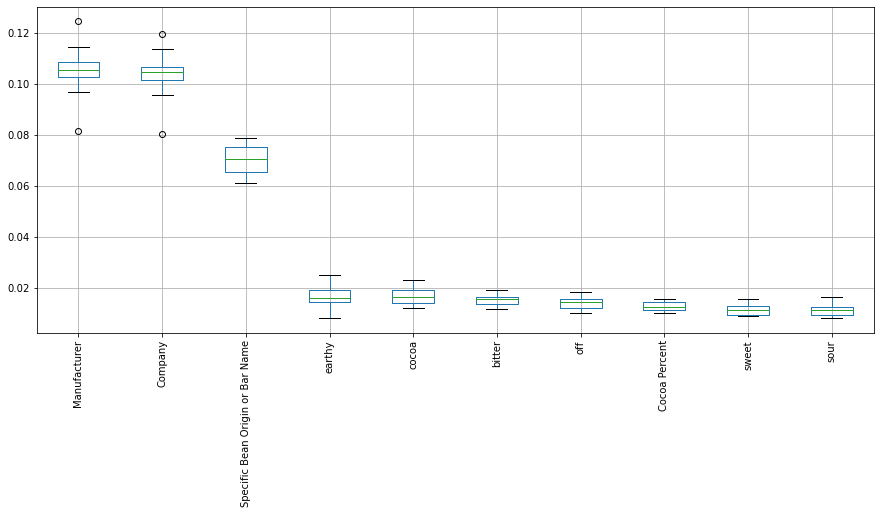

In [32]:
fig, ax = plt.subplots(figsize=(15, 6))
importances.iloc[:, :10].boxplot()
plt.xticks(rotation=90);

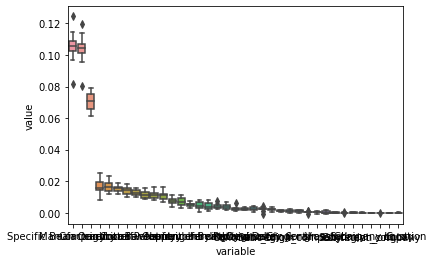

In [33]:
sns.boxplot(x="variable", y="value", data=pd.melt(importances));

In [34]:
importances = pd.DataFrame({'feature': feature_names, 
                            'importances_mean': pi.importances_mean, 
                            'importances_std': pi.importances_std})
importances.sort_values('importances_mean', ascending=False)[:15]

,feature,importances_mean,importances_std
9,Manufacturer,0.105017,0.010557
10,Company,0.103434,0.009975
3,Specific Bean Origin or Bar Name,0.070193,0.005960
16,earthy,0.017013,0.004703
15,cocoa,0.016849,0.003529
30,bitter,0.015257,0.002202
29,off,0.014030,0.002426
4,Cocoa Percent,0.012817,0.001848
17,sweet,0.011402,0.002138
18,sour,0.011380,0.002391


## SVM

In [167]:
svr_mod = Pipeline([('cat_enc', CatEncoder('GLMMEncoder')), 
                   ('scaler', num_enc), 
                   ('svr', SVR())])
svr_mod.fit(X_train, y_train)

Pipeline(steps=[('cat_enc', <__main__.CatEncoder object at 0x0000022BAC632FC8>),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Review Date',
                                                   'Cocoa Percent'])])),
                ('svr', SVR())])

In [168]:
params = {'svr__kernel': ['rbf', 'linear', 'poly'], 
          'svr__C': [0.03, 0.1, 0.3, 1, 3], 
          'svr__epsilon': [0.03, 0.1, 0.3, 1]}

gs = GridSearchCV(svr_mod, params, 
                  cv=5, 
                  scoring='neg_root_mean_squared_error', 
                  return_train_score=True,
                  n_jobs=-1,
                  verbose=3)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cat_enc',
                                        <__main__.CatEncoder object at 0x0000022BAC632FC8>),
                                       ('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Review '
                                                                          'Date',
                                                                          'Cocoa '
                                                                          'Percent'])])),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.03, 0.1, 0.3, 1, 3],
                         'svr__epsilon': [0.03, 0.1, 0

In [169]:
# Show best parameters
gs.best_params_

{'svr__C': 0.1, 'svr__epsilon': 0.03, 'svr__kernel': 'rbf'}

In [170]:
# Compare the train and test scores
results = pd.DataFrame(gs.cv_results_)
results.loc[results['mean_test_score'] == gs.best_score_, ['mean_train_score', 'mean_test_score']]

,mean_train_score,mean_test_score
12,-0.293435,-0.376526


In [171]:
svr_best_mod = gs.best_estimator_

In [172]:
eval_mod(svr_best_mod)

RMSE: 0.3925465816174548
MAE: 0.3055427844748745
R^2: 0.2908383384883748


In [173]:
encoders = ['CatBoostEncoder', 'GLMMEncoder', 'JamesSteinEncoder', 
            'LeaveOneOutEncoder', 'MEstimateEncoder', 'TargetEncoder']

for enc in encoders:
    svr_mod = Pipeline([('cat_enc', CatEncoder(enc)), 
                   ('scaler', num_enc), 
                   ('svr', SVR(C=0.3, epsilon=0.03))])
    svr_mod.fit(X_train, y_train)
    print(enc)
    eval_mod(svr_mod)
    print()

CatBoostEncoder
RMSE: 0.4017946806446094
MAE: 0.31302068828373875
R^2: 0.257030107773878

GLMMEncoder
RMSE: 0.38735918727134977
MAE: 0.30457430278435055
R^2: 0.30945724822225396

JamesSteinEncoder
RMSE: 0.43104572858412027
MAE: 0.34300967180712133
R^2: 0.1449145020048418

LeaveOneOutEncoder
RMSE: 0.40518105499872453
MAE: 0.31568922551660733
R^2: 0.24445365129696883

MEstimateEncoder
RMSE: 0.40706834332946445
MAE: 0.31841339736634017
R^2: 0.2373987571442423

TargetEncoder
RMSE: 0.40275669472550124
MAE: 0.31417629515351037
R^2: 0.25346807378069736

